In [ ]:
#User to install seaborn, pandas, db-dtypes, scikit-learn and xgboost if haven't already done so
#User to authenticate account with the gcloud CLI, if havent already done so

# Brazilian E-Commerce (Olist) – Exploratory Data Analysis (EDA)

This notebook is part of the **end-to-end data pipeline**:

- Kaggle → CSV → Meltano → BigQuery  
- dbt → Star Schema (fact + dim tables)  
- Great Expectations → Data Quality  
- **Python (this notebook) → Exploratory Data Analysis**  
- ML model notebook  
- HTML / Plotly dashboard

**Audience:** Data engineers, analytics engineers, and data scientists.  
**Warehouse:** BigQuery  
**Schema:** `ecommerce` (dbt outputs)

## 0. Setup & Imports

This section:

- Imports core Python libraries  
- Creates a BigQuery client (using Application Default Credentials or a service account)  
- Sets some display and plotting defaults

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery

# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)
sns.set(style="whitegrid", palette="deep")

PROJECT_ID = "durable-ripsaw-477914-g0"  # <-- change if needed
DATASET = "ecommerce"                    # dbt output dataset

client = bigquery.Client(project=PROJECT_ID)
print("✅ BigQuery client initialised for project:", PROJECT_ID)

/opt/anaconda3/envs/elt/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.18) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


✅ BigQuery client initialised for project: durable-ripsaw-477914-g0


## Load dbt Star-Schema Tables

We **never** run EDA directly on raw CSVs.  
Instead we consume **cleaned, modeled tables** produced by dbt and validated by Great Expectations:

- `dim_customers`
- `dim_products`
- `dim_sellers`
- `fact_orders`

These should correspond to your dbt models.


In [2]:
def load_table(table_name: str) -> pd.DataFrame:
    """Helper to load a table from BigQuery into pandas."""
    query = f"""SELECT * FROM `{PROJECT_ID}.{DATASET}.{table_name}`"""
    print(f"\n▶ Loading {PROJECT_ID}.{DATASET}.{table_name} ...")
    df = client.query(query).to_dataframe()
    print(f"   Shape: {df.shape}")
    return df

df_customers = load_table("dim_db_customers")
df_sellers   = load_table("dim_db_sellers")
df_products  = load_table("dim_db_products")
df_orders    = load_table("fact_db_order_items")  # fact table from dbt

df_customers.head()


▶ Loading durable-ripsaw-477914-g0.ecommerce.dim_db_customers ...


/opt/anaconda3/envs/elt/lib/python3.10/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   Shape: (99441, 5)

▶ Loading durable-ripsaw-477914-g0.ecommerce.dim_db_sellers ...
   Shape: (3095, 4)

▶ Loading durable-ripsaw-477914-g0.ecommerce.dim_db_products ...
   Shape: (32951, 7)

▶ Loading durable-ripsaw-477914-g0.ecommerce.fact_db_order_items ...
   Shape: (112650, 9)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,929cb7b1618f0d99c7814d79b0c5b7cc,3cd07f2cd0e3bd52f3896c0048fb37c7,69900,rio branco,AC
1,0f32385df13e46d88d997460208bc866,4f67110f6d6d1241111167b141bfa780,69900,rio branco,AC
2,f34e32b8604090d1c2a7f3b04c834807,785a8a410d6fc9661d66f7218a87229d,69900,rio branco,AC
3,2d618e470c95c9b425cbb0cbc42683dd,f7d7fc0a59ef4363fdce6e3aa069d498,69900,rio branco,AC
4,cd281c1a7d26cd29a3ed4b029fce7270,086d6b5b5ba195a91aa0a6ec8e75d1a4,69900,rio branco,AC


## Basic Data Health Checks

Even though dbt + Great Expectations have already validated the data,  
it's good practice to perform **quick sanity checks** in the notebook:

- Missing values by column  
- Basic descriptive statistics  
- Key date ranges

In [3]:
df_customers.info()
df_sellers.info()
df_products.info()
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   seller_id     3095 non-null   object
 1   seller_zip    3095 non-null   object
 2   seller_city   3095 non-null   object
 3   seller_state  3095 non-null   object
dtypes: object(4)
memory usage: 96.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950

In [4]:
df_customers.describe()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,929cb7b1618f0d99c7814d79b0c5b7cc,8d50f5eadf50201ccdcedfb9e2ac8455,22790,sao paulo,SP
freq,1,17,142,15540,41746


In [5]:
df_sellers.describe()

,seller_id,seller_zip,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,4be2e7f96b4fd749d52dff41f80e39dd,14940,sao paulo,SP
freq,1,49,694,1849


In [6]:
df_products.describe()

,product_id,product_category_name,product_category_name_english,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32951,32328,32951,32951,32951,32951
unique,32951,74,71,2205,100,103,96
top,5eb564652db742ff8f28759cd8d2652a,cama_mesa_banho,bed_bath_table,200.0,16.0,10.0,11.0
freq,1,3029,3029,2084,5520,2548,3718


In [7]:
df_orders.describe()

,order_id,order_item_id,product_id,seller_id,customer_id,order_date_key,price,freight_value,gross_order_item_value
count,112650,112650,112650,112650,112650,112650,112650,112650,112650
unique,98666,21,32951,3095,98666,616,5968,6999,25547
top,8272b63d03f5f79c56e9e4120aec44ef,1,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,fc3d1daec319d62d49bfb5e1f83123e9,2017-11-24,59.900000000,15.100000000,77.570000000
freq,21,98666,527,2033,21,1366,2481,3707,437


In [8]:
print("\n🔍 Missing values in fact_orders:")
print(df_orders.isna().sum().sort_values(ascending=False))

print("\n📊 Descriptive statistics (numeric columns):")
display(df_orders.describe())

if 'order_date_key' in df_orders.columns:
    df_orders['order_date_key'] = pd.to_datetime(df_orders['order_date_key'])
    print("\n⏱ Purchase timestamp range:")
    print(df_orders['order_date_key'].min(), "→", df_orders['order_date_key'].max())


🔍 Missing values in fact_orders:
order_id                  0
order_item_id             0
product_id                0
seller_id                 0
customer_id               0
order_date_key            0
price                     0
freight_value             0
gross_order_item_value    0
dtype: int64

📊 Descriptive statistics (numeric columns):


,order_id,order_item_id,product_id,seller_id,customer_id,order_date_key,price,freight_value,gross_order_item_value
count,112650,112650,112650,112650,112650,112650,112650,112650,112650
unique,98666,21,32951,3095,98666,616,5968,6999,25547
top,8272b63d03f5f79c56e9e4120aec44ef,1,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,fc3d1daec319d62d49bfb5e1f83123e9,2017-11-24,59.900000000,15.100000000,77.570000000
freq,21,98666,527,2033,21,1366,2481,3707,437



⏱ Purchase timestamp range:
2016-09-04 00:00:00 → 2018-09-03 00:00:00


## Monthly Sales Trend

Objective for technical engineering:

- Verify that date logic is correct  
- Confirm that **aggregation over fact_orders** works as expected  
- Provide a high-level volume view for business stakeholders

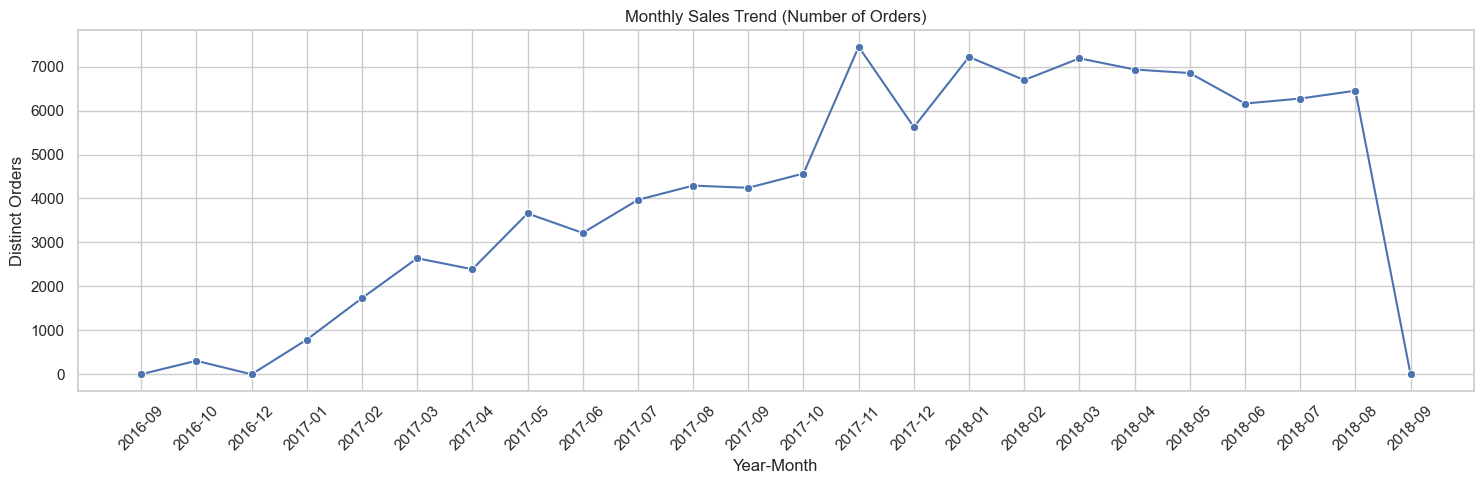

,year_month,num_orders
19,2018-05,6853
20,2018-06,6160
21,2018-07,6273
22,2018-08,6452
23,2018-09,1


In [9]:
# Create year-month column
df_orders['year_month'] = df_orders['order_date_key'].dt.to_period('M').astype(str)

# Compute monthly distinct orders
monthly_sales = (
    df_orders
    .groupby('year_month')['order_id']
    .nunique()
    .reset_index(name='num_orders')
)

# Plot
plt.figure(figsize=(15,5))
sns.lineplot(data=monthly_sales, x='year_month', y='num_orders', marker="o")
plt.title("Monthly Sales Trend (Number of Orders)")
plt.xlabel("Year-Month")
plt.ylabel("Distinct Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show last few rows
monthly_sales.tail()

## Top Product Categories

We now combine the **fact_orders** table with **dim_products** to get  
the top-selling product categories by order item count.


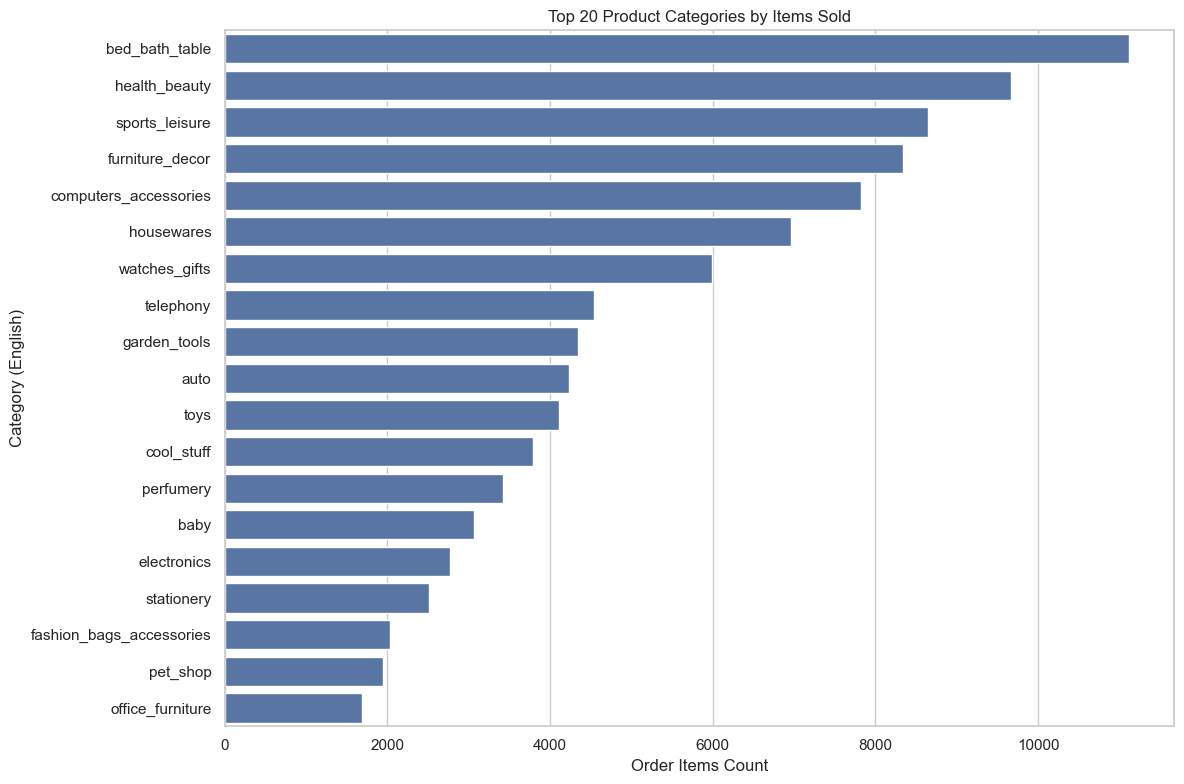

,product_category_name_english,order_items
0,bed_bath_table,11115
1,health_beauty,9670
2,sports_leisure,8641
3,furniture_decor,8334
4,computers_accessories,7827
5,housewares,6964
6,watches_gifts,5991
7,telephony,4545
8,garden_tools,4347
9,auto,4235


In [10]:
# Ensure we only keep relevant product columns
product_cols = ['product_id', 'product_category_name', 'product_category_name_english']
product_cols = [c for c in product_cols if c in df_products.columns]

df_orders_products = df_orders.merge(
    df_products[product_cols],
    on='product_id',
    how='left'
)

top_categories = (
    df_orders_products
    .groupby('product_category_name_english', dropna=False)['order_item_id']
    .count()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(12,8))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 20 Product Categories by Items Sold")
plt.xlabel("Order Items Count")
plt.ylabel("Category (English)")
plt.tight_layout()
plt.show()

top_categories.to_frame(name='order_items').reset_index().head(10)

## Customer Segmentation – RFM (Recency, Frequency, Monetary)

We create **RFM features** from fact_orders:

- **Recency**: Days since last purchase  
- **Frequency**: Number of distinct orders  
- **Monetary**: Total gross order value

These RFM features are also good **inputs for ML models** later.


In [11]:
df_orders['order_purchase_timestamp'] = df_orders['order_date_key']

df_orders['order_date'] = df_orders['order_purchase_timestamp'].dt.date
df_orders['gross_order_item_value'] = (
    df_orders['gross_order_item_value']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(float)
)

snapshot_date = df_orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

In [12]:
rfm = (
    df_orders
    .groupby('customer_id')
    .agg({
        'order_date': lambda x: (snapshot_date.date() - max(x)).days,
        'order_id': 'nunique',
        'gross_order_item_value': 'sum'
    })
    .rename(columns={
        'order_date': 'Recency',
        'order_id': 'Frequency',
        'gross_order_item_value': 'Monetary'
    })
)


RFM shape: (98666, 3)


,Recency,Frequency,Monetary
count,98666.000000,98666.0,98666.000000
mean,246.716062,1.0,160.577638
std,153.392938,0.0,220.466087
min,1.000000,1.0,9.590000
25%,123.000000,1.0,61.980000
50%,228.000000,1.0,105.290000
75%,357.000000,1.0,176.870000
max,730.000000,1.0,13664.080000


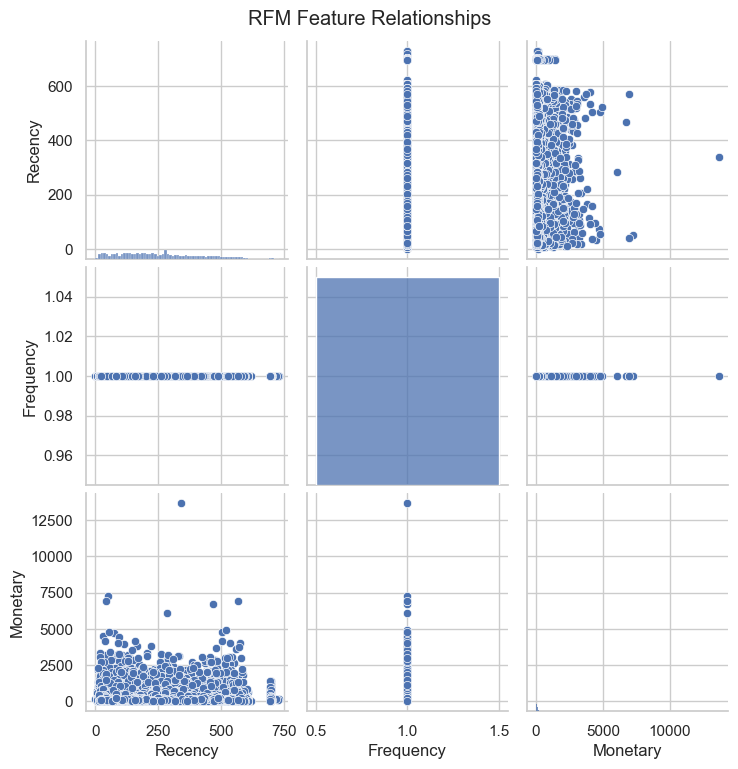

In [13]:
print("RFM shape:", rfm.shape)
display(rfm.describe())

sns.pairplot(rfm.reset_index()[['Recency', 'Frequency', 'Monetary']])
plt.suptitle("RFM Feature Relationships", y=1.02)
plt.show()


## Freight vs Price Relationship

This checks whether freight cost is proportional to product price,  
which may indicate **pricing policy or carrier rules**.

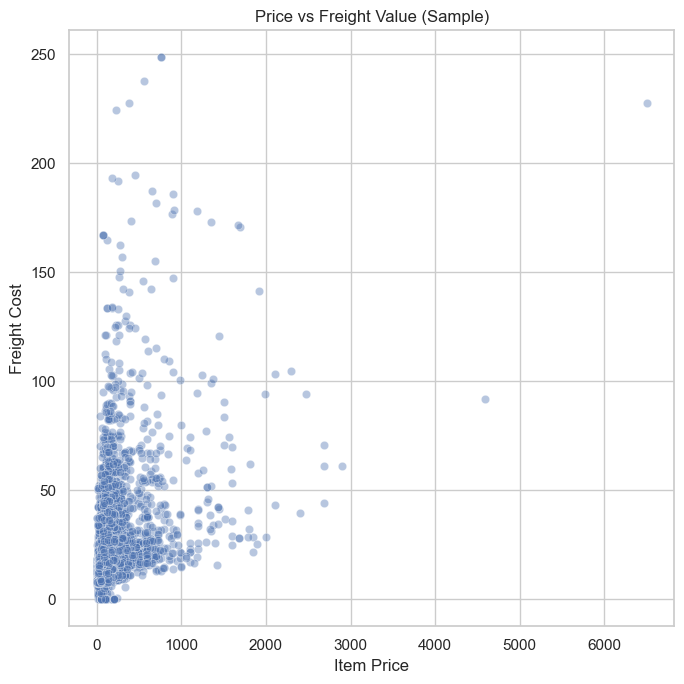

,price,freight_value
price,1.000000,0.414672
freight_value,0.414672,1.000000


In [14]:
sample_df = df_orders[['price', 'freight_value']].dropna().copy()
if len(sample_df) > 10000:
    sample_df = sample_df.sample(10000, random_state=42)

plt.figure(figsize=(7,7))
sns.scatterplot(data=sample_df, x='price', y='freight_value', alpha=0.4)
plt.title("Price vs Freight Value (Sample)")
plt.xlabel("Item Price")
plt.ylabel("Freight Cost")
plt.tight_layout()
plt.show()

sample_df.corr()

## Seller Regional Activity

Use **dim_sellers** joined with **fact_orders** to identify high-activity regions.

This is useful for:

- Network planning  
- Capacity planning  
- Regional campaigns

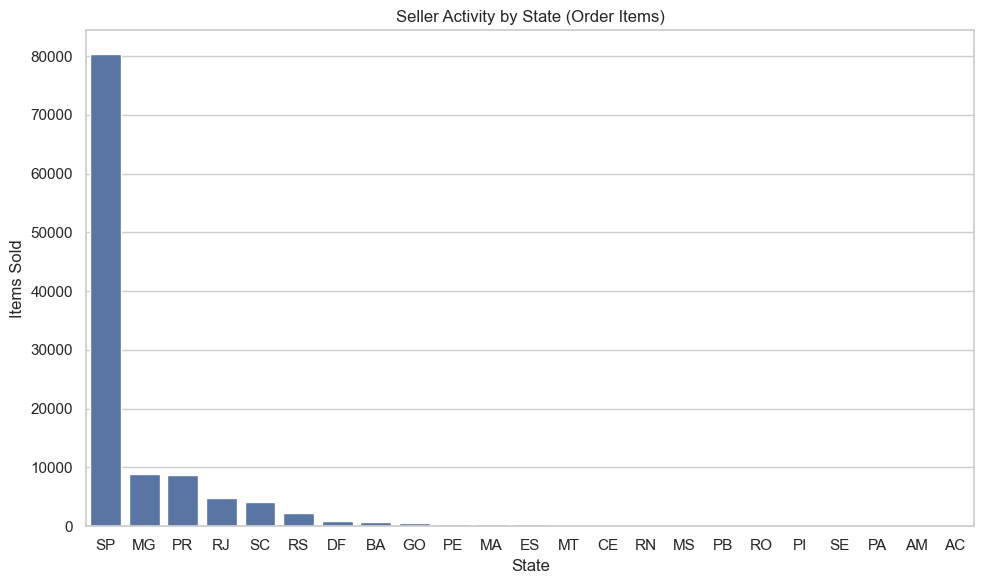

In [15]:
# Clean deduped dim table
df_sellers_unique = (
    df_sellers.groupby('seller_id')['seller_state']
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

df_sellers_unique['seller_state'] = (
    df_sellers_unique['seller_state']
    .astype(str)
    .str.upper()
    .str.strip()
)

# Merge to fact
df_orders_sellers = df_orders.merge(
    df_sellers_unique,
    on='seller_id',
    how='left',
    validate='many_to_one'
)

# Compute seller activity
seller_activity = (
    df_orders_sellers
    .groupby('seller_state')['order_item_id']
    .count()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(x=seller_activity.index, y=seller_activity.values)
plt.title("Seller Activity by State (Order Items)")
plt.xlabel("State")
plt.ylabel("Items Sold")
plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
# Ensure numeric types for aggregation
df_orders['gross_order_item_value'] = pd.to_numeric(df_orders['gross_order_item_value'], errors='coerce')
df_orders['freight_value'] = pd.to_numeric(df_orders['freight_value'], errors='coerce')
df_orders['price'] = pd.to_numeric(df_orders['price'], errors='coerce')

# Aggregate orders per customer
orders_agg = (
    df_orders
    .groupby('customer_id')
    .agg(
        total_revenue=('gross_order_item_value', 'sum'),
        total_freight=('freight_value', 'sum')
    )
    .reset_index()
)

# Merge with customer info
df_features = df_customers.merge(
    orders_agg,
    on='customer_id',
    how='left'
)

# Select only required columns
df_features = df_features[[
    'customer_id',
    'customer_state',
    'customer_zip_code_prefix',  # maps to customer_zip
    'total_revenue',
    'total_freight',
]]

df_features.head()


,customer_id,customer_state,customer_zip_code_prefix,total_revenue,total_freight
0,929cb7b1618f0d99c7814d79b0c5b7cc,AC,69900,70.38,25.38
1,0f32385df13e46d88d997460208bc866,AC,69900,94.37,42.39
2,f34e32b8604090d1c2a7f3b04c834807,AC,69900,361.27,61.27
3,2d618e470c95c9b425cbb0cbc42683dd,AC,69900,102.57,27.58
4,cd281c1a7d26cd29a3ed4b029fce7270,AC,69900,995.18,33.58


In [18]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               99441 non-null  object 
 1   customer_state            99441 non-null  object 
 2   customer_zip_code_prefix  99441 non-null  object 
 3   total_revenue             98666 non-null  float64
 4   total_freight             98666 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.8+ MB


In [19]:
df_features_cleaned = df_features.dropna()

In [20]:
df_features_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98666 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               98666 non-null  object 
 1   customer_state            98666 non-null  object 
 2   customer_zip_code_prefix  98666 non-null  object 
 3   total_revenue             98666 non-null  float64
 4   total_freight             98666 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.5+ MB


In [21]:
y = df_features_cleaned['total_freight']
X = df_features_cleaned.drop(columns=['total_freight','customer_id'])

In [22]:
num_features = ['customer_zip_code_prefix','total_revenue']
cat_features = ['customer_state']

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 78932
Testing samples: 19734


In [24]:
# Numeric transformer: fill missing values, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # fill NaN with mean
    ('scaler', StandardScaler())
])

# Categorical transformer: fill missing values, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill NaN with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'  # drop other columns
)

In [25]:
def evaluate_model(model_name, y_true, y_pred):
    """Calculates and prints key regression performance metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} Performance ---")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-" * 40)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [26]:
print("Starting Linear Regression (Baseline) Training...")

# Create the full pipeline for Linear Regression
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
lr_metrics = evaluate_model("Linear Regression (Baseline)", y_test, y_pred_lr)

Starting Linear Regression (Baseline) Training...
--- Linear Regression (Baseline) Performance ---
Root Mean Squared Error (RMSE): 21.55
Mean Absolute Error (MAE): 8.79
R-squared (R2): 0.2682
----------------------------------------


In [27]:
from xgboost import XGBRegressor

print("Starting XGBoost Training...")

# Create the full pipeline for XGBoost
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
         objective='reg:squarederror',
    n_estimators=500,  # Number of boosting rounds
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1, # Use all available cores
    tree_method='hist' # Faster tree cons
    ))
])


# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
xgb_metrics = evaluate_model("XGBoost Regressor", y_test, y_pred_xgb)

Starting XGBoost Training...
--- XGBoost Regressor Performance ---
Root Mean Squared Error (RMSE): 21.74
Mean Absolute Error (MAE): 8.52
R-squared (R2): 0.2550
----------------------------------------
